In [1]:
import pandas as pd
import numpy as np
from surprise import SVD, SlopeOne, KNNBasic
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, cosine, jaccard
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("./kmeans_data/data.csv", header=None)
label_data = pd.read_csv("./kmeans_data/label.csv", header=None)

df = pd.DataFrame(data)
df['label'] = label_data
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [3]:
def kmeans(data, k, method):
    X = data.copy()

    # Ensure initial centroids have distinct labels
    while True:
        '''
        indices = np.random.choice(len(X), k, replace=False)
        centroids = X.iloc[indices]
        '''
        centroids = []
        centroids.append(X.sample(1).iloc[0])
        for _ in range(k - 1):
            distances = cdist(X, centroids, metric='euclidean')
            min_distances = np.min(distances, axis=1)
            next_centroid = X.iloc[np.argmax(min_distances)]
            centroids.append(next_centroid)

        centroids = pd.DataFrame(centroids)

        if centroids['label'].nunique() == k:
            break
        


    assign_to_label = {i: label for i, label in enumerate(centroids['label'])}
    centroids = centroids.reset_index(drop=True)


    iterations = 0
    curr_max_diff = 0
    prior_max_diff = 0
    priorX = pd.DataFrame()
    X_array = X.values[:, :-1]
    while True:
        sse = 0
        centroids_array = centroids.values[:, :-1]

        if method == "euclidean":
            # distances = np.linalg.norm(X.values[:, np.newaxis, :-1] - centroids.values[:, :-1], axis=2)
            distances = cdist(X_array, centroids_array, metric='euclidean')
        elif method == "cosine":
            distances = cdist(X_array, centroids_array, metric='cosine')
        else:
            distances = cdist(X_array, centroids_array, metric='jaccard')

        assign = np.argmin(distances, axis=1)
        labels = [assign_to_label[i] for i in assign]

        '''
        if len(priorX) != 0:
            display((priorX != X).sum().sum())
        priorX = X
        '''
        X['label'] = labels

        new_centroids = X.groupby('label').mean().round(0).astype(int).reset_index()
        new_centroids.columns.name = None  # Remove the label from the columns
        new_centroids['label'] = new_centroids['label'].astype(int)
        new_centroids = pd.concat([new_centroids.drop('label', axis=1), new_centroids['label']], axis=1)

        changed_rows = centroids[centroids.ne(new_centroids).any(axis=1)]
        # Iterate over changed rows and columns
        
        for index, row in changed_rows.iterrows():
            for col in centroids.columns:
                curr_max_diff = max(abs(row[col] - new_centroids.at[index, col]), curr_max_diff)
                '''
                if abs(row[col] - new_centroids.at[index, col]) > 1:
                    print(f"Row {index}, Column {col} changed from {centroids.at[index, col]} to {new_centroids.at[index, col]}")
                '''
        
        '''
        if not np.not_equal(centroids.values, new_centroids.values).any():
            display("made it")
            break
        '''
        
        '''
        if centroids.sort_values(by=list(centroids.columns)).equals(new_centroids.sort_values(by=list(new_centroids.columns))):
            display("made it")
            break
        '''
        
        '''
        if np.allclose(centroids.values, new_centroids.values, atol=150):
            break
        '''
        
        
        # Calculate SSE
        for i, centroid in enumerate(centroids['label']):
            cluster_points = X[X['label'] == centroid].iloc[:, :-1]
            sse += np.sum((cluster_points.values - centroids.iloc[i, :-1].values) ** 2)

        if prior_max_diff == curr_max_diff:
            display(iterations)
            break
        
        prior_max_diff = curr_max_diff
        curr_max_diff = 0

        centroids = new_centroids
        new_centroids = pd.DataFrame()
        iterations += 1

    return centroids, sse

y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)

euclidean_centroids, euclidean_sse = kmeans(train_df, 10, "euclidean")
display(f"Euclidean SSE: {euclidean_sse}")

cosine_centroids, cosine_sse = kmeans(train_df, 10, "cosine")
display(f"Cosine SSE: {cosine_sse}")

jaccard_centroids, jaccard_sse = kmeans(train_df, 10, "jaccard")
display(f"Jaccard SSE: {jaccard_sse}")



4

'Euclidean SSE: 42156286009'

6

'Cosine SSE: 32321855534'

9

'Jaccard SSE: 27455442565'

In [4]:
def kmeans_fit_predict(test_data, centroids, method):
    test = test_data.copy()
    X_test_array = test.values[:, :-1]
    centroids_array = centroids.values[:, :-1]

    assign_to_label = {i: label for i, label in enumerate(centroids['label'])}
    
    if method == "euclidean":
        distances = cdist(X_test_array, centroids_array, metric='euclidean')
    elif method == "cosine":
        distances = cdist(X_test_array, centroids_array, metric='cosine')
    else:
        distances = cdist(X_test_array, centroids_array, metric='jaccard')

    assign = np.argmin(distances, axis=1)
    labels = [assign_to_label[i] for i in assign]
    test['pred_label'] = labels

    accuracy = accuracy_score(test['label'], test['pred_label'])
    return accuracy
    

test_df = pd.concat([X_test, y_test], axis=1)
euclidean_accuracy = kmeans_fit_predict(test_df, euclidean_centroids, "euclidean")
display(f"Euclidean Accuracy: {euclidean_accuracy}")

cosine_accuracy = kmeans_fit_predict(test_df, cosine_centroids, "cosine")
display(f"Cosine Accuracy: {cosine_accuracy}")

jaccard_accuracy = kmeans_fit_predict(test_df, jaccard_centroids, "jaccard")
display(f"Jaccard Accuracy: {jaccard_accuracy}")


'Euclidean Accuracy: 0.0655'

'Cosine Accuracy: 0.4775'

'Jaccard Accuracy: 0.099'

In [5]:
def stop_criteria_kmeans(data, k, max_iter, method):
    X = data.copy()

    # Ensure initial centroids have distinct labels
    while True:
        indices = np.random.choice(len(X), k, replace=False)
        centroids = X.iloc[indices]
        if centroids['label'].nunique() == k:
            break

    assign_to_label = {i: label for i, label in enumerate(centroids['label'])}
    centroids = centroids.reset_index(drop=True)

    prior_sse = 0
    iterations = 0
    while True:
        sse = 0
        X_array = X.values[:, :-1]
        centroids_array = centroids.values[:, :-1]

        if method == "euclidean":
            # distances = np.linalg.norm(X.values[:, np.newaxis, :-1] - centroids.values[:, :-1], axis=2)
            distances = cdist(X_array, centroids_array, metric='euclidean')
        elif method == "cosine":
            distances = cdist(X_array, centroids_array, metric='cosine')
        else:
            distances = cdist(X_array, centroids_array, metric='jaccard')

        assign = np.argmin(distances, axis=1)
        labels = [assign_to_label[i] for i in assign]
        X['label'] = labels

        new_centroids = X.groupby('label').mean().round(0).astype(int).reset_index()
        new_centroids.columns.name = None  # Remove the label from the columns
        new_centroids['label'] = new_centroids['label'].astype(int)
        new_centroids = pd.concat([new_centroids.drop('label', axis=1), new_centroids['label']], axis=1)
    
        # Calculate SSE
        for i, centroid in enumerate(centroids['label']):
            cluster_points = X[X['label'] == centroid].iloc[:, :-1]
            sse += np.sum((cluster_points.values - centroids.iloc[i, :-1].values) ** 2)

        if not np.not_equal(centroids.values, new_centroids.values).any() or sse > prior_sse and prior_sse != 0 or iterations == max_iter:
            display(iterations)
            break
        
        prior_sse = sse

        centroids = new_centroids
        new_centroids = pd.DataFrame()

        iterations += 1

    return centroids, sse

y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)

euclidean_centroids, euclidean_sse = stop_criteria_kmeans(train_df, 10, 500, "euclidean")
display(f"Euclidean SSE: {euclidean_sse}")

cosine_centroids, cosine_sse = stop_criteria_kmeans(train_df, 10, 500, "cosine")
display(f"Cosine SSE: {cosine_sse}")

jaccard_centroids, jaccard_sse = stop_criteria_kmeans(train_df, 10, 500, "jaccard")
display(f"Jaccard SSE: {jaccard_sse}")

2

'Euclidean SSE: 35448019380'

2

'Cosine SSE: 33515784592'

5

'Jaccard SSE: 27457789618'

In [5]:
# Task 2
pd_data = pd.read_csv('ratings_small.csv')
df = pd.DataFrame(pd_data)

reader = Reader(rating_scale=(1,5), line_format="userID movieID rating timestamp")

df = df.drop(['timestamp'], axis=1)

data = Dataset.load_from_df(df[list(df.columns)], reader)

# Uses the famous SVD algorithm. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=matrix
pmf = SVD(biased=False)
# Slope One uses an Item-Item Based Collaborative Filtering
s1 = SlopeOne()
# KNN Basic uses an User-User based Collaborative Filtering or an Item-Item Based Collaborative Filtering
knn_user = KNNBasic(sim_options={'user_based': True})
knn_item = KNNBasic(sim_options={'user_based': False})

# Run 5-fold cross-validation and print results.
pmf_res = cross_validate(pmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) # pmf results

knn_user_res = cross_validate(knn_user, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) # knn_user results

knn_item_res = cross_validate(knn_item, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) # knn_item results
slope_one_res = cross_validate(s1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) # slope one results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0097  1.0019  1.0048  1.0119  1.0171  1.0091  0.0053  
MAE (testset)     0.7809  0.7750  0.7742  0.7801  0.7869  0.7794  0.0046  
Fit time          1.01    0.97    0.96    1.08    1.37    1.08    0.15    
Test time         0.20    0.10    0.17    0.10    0.42    0.20    0.12    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9714  0.9710  0.9662  0.9631  0.9717  0.9686  0.0034

KeyboardInterrupt: 

In [7]:
# Lists to store metric values for plotting
ubcf_rmse_values = []
ubcf_mae_values = []
ibcf_rmse_values = []
ibcf_mae_values = []

similarity_metrics = ['cosine', 'msd', 'pearson']

for metric in similarity_metrics:
    # User-based Collaborative Filtering
    ubcf_model = KNNBasic(sim_options={'name': metric, 'user_based': True})
    ubcf_results = cross_validate(ubcf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    ubcf_rmse_values.append(np.mean(ubcf_results['test_rmse']))
    ubcf_mae_values.append(np.mean(ubcf_results['test_mae']))

    # Item-based Collaborative Filtering
    ibcf_model = KNNBasic(sim_options={'name': metric, 'user_based': False})
    ibcf_results = cross_validate(ibcf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    ibcf_rmse_values.append(np.mean(ibcf_results['test_rmse']))
    ibcf_mae_values.append(np.mean(ibcf_results['test_mae']))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

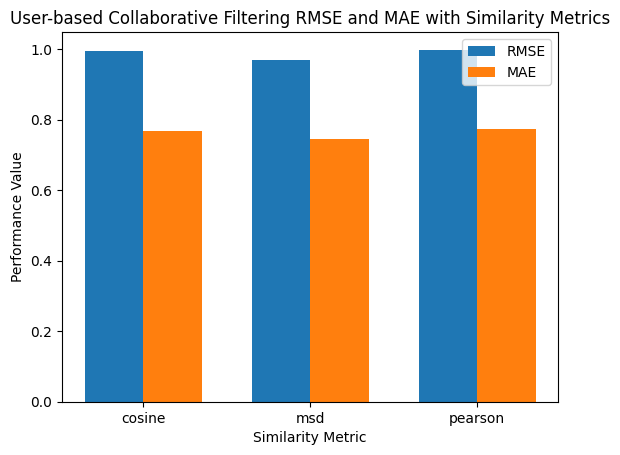

In [8]:
# Plotting RMSE and MAE side by side
fig, ax = plt.subplots()
width = 0.35
x = np.arange(len(similarity_metrics))

# Calculate the x-coordinates for MAE bars (shifted by the bar width)
ubcf_rmse_bars = ax.bar(x - width/2, ubcf_rmse_values, width, label='RMSE')
ubcf_mae_bars = ax.bar(x + width/2, ubcf_mae_values, width, label='MAE')

ax.set_xticks(x)
ax.set_xticklabels(similarity_metrics)
ax.legend()
ax.set_xlabel('Similarity Metric')
ax.set_ylabel('Performance Value')
ax.set_title('User-based Collaborative Filtering RMSE and MAE with Similarity Metrics')

plt.show()


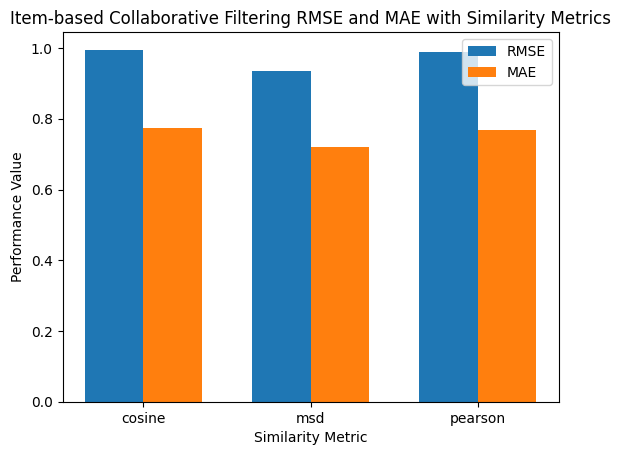

In [9]:
fig, ax = plt.subplots()
width = 0.35
x = np.arange(len(similarity_metrics))
# Calculate the x-coordinates for MAE bars (shifted by the bar width)
ibcf_rmse_bars = ax.bar(x - width/2, ibcf_rmse_values, width, label='RMSE')
ibcf_mae_bars = ax.bar(x + width/2, ibcf_mae_values, width, label='MAE')

ax.set_xticks(x)
ax.set_xticklabels(similarity_metrics)
ax.legend()
ax.set_xlabel('Similarity Metric')
ax.set_ylabel('Performance Value')
ax.set_title('Item-based Collaborative Filtering RMSE and MAE with Similarity Metrics')

plt.show()

In [10]:
# Lists to store metric values for plotting
ubcf_rmse_values = []
ubcf_mae_values = []
ibcf_rmse_values = []
ibcf_mae_values = []

for K in range(1, 11):
    # User-based Collaborative Filtering
    ubcf_model = KNNBasic(k=K, min_k=K, sim_options={'user_based': True})
    ubcf_results = cross_validate(ubcf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    ubcf_rmse_values.append(np.mean(ubcf_results['test_rmse']))
    ubcf_mae_values.append(np.mean(ubcf_results['test_mae']))

    # Item-based Collaborative Filtering
    ibcf_model = KNNBasic(k=K, min_k=K, sim_options={'user_based': False})
    ibcf_results = cross_validate(ibcf_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    ibcf_rmse_values.append(np.mean(ibcf_results['test_rmse']))
    ibcf_mae_values.append(np.mean(ibcf_results['test_mae']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

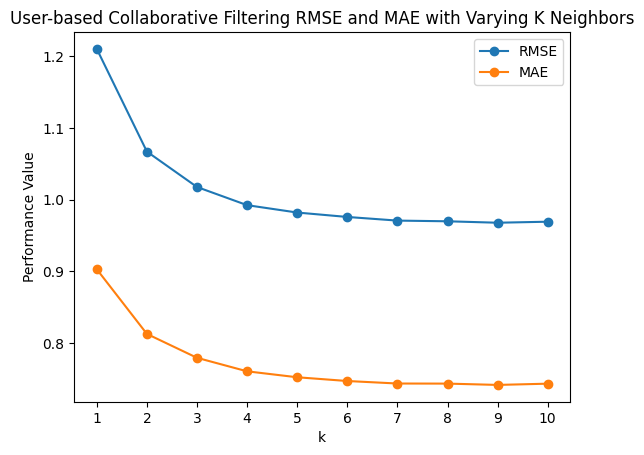

In [11]:
fig, ax = plt.subplots()
ax.plot(range(1,11), ubcf_rmse_values, label='RMSE', marker='o')
ax.plot(range(1,11), ubcf_mae_values, label='MAE', marker='o')

ax.set_xticks(range(1,11))
ax.set_xlabel('k')
ax.set_ylabel('Performance Value')
ax.legend()
ax.set_title('User-based Collaborative Filtering RMSE and MAE with Varying K Neighbors')

plt.show()

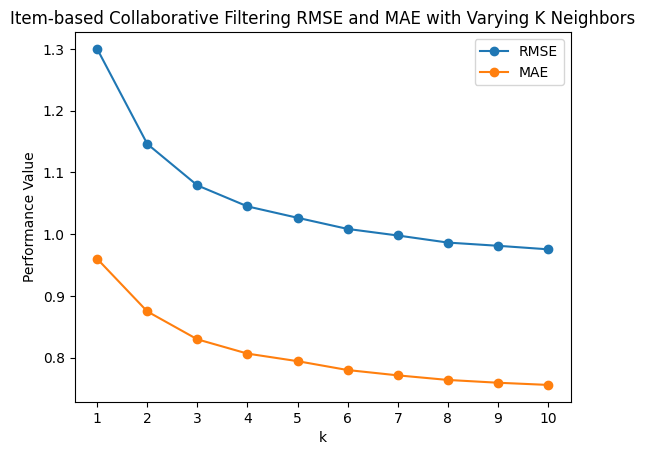

In [12]:
fig, ax = plt.subplots()
ax.plot(range(1,11), ibcf_rmse_values, label='RMSE', marker='o')
ax.plot(range(1,11), ibcf_mae_values, label='MAE', marker='o')

ax.set_xticks(range(1,11))
ax.set_xlabel('k')
ax.set_ylabel('Performance Value')
ax.legend()
ax.set_title('Item-based Collaborative Filtering RMSE and MAE with Varying K Neighbors')

plt.show()